In [1]:
#Импорты библиотек
import pandas as pd
import numpy as np

from StandartScaler import OnlineStandartScaler

from comet_ml import Experiment
from comet_ml.integration.sklearn import log_model

import warnings 
warnings.filterwarnings("ignore")

from imblearn.under_sampling import RandomUnderSampler

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.utils import class_weight
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

import xgboost
import catboost

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-v0_8')

from sklearn import preprocessing

In [2]:
#Инициализируем эксперимент для comet.ml
experiment = Experiment(
  api_key="7OG1voSLXiuymKjZfEDg00rMB",
  project_name="motorica-first-sprint",
  workspace="gdudyrev"
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/gdudyrev/motorica-first-sprint/4fec13f9351f496c9b71103bd497ed6e



## Задача
Необходимо обучитть модель, которая сможет предсказывать жесты пилота с помощью показаний с оптомографических датчиков.

## Цели на спринт

1. Избавиться от естественной задержки пилота
2. Сгенерировать признаки на основе данных
3. Придумать способ борьбы с несбалансированностью классов
4. Подумать, как можно будет преобразовывать данные в онлайн

Перед началом работы зафиксируем случайность

In [3]:
random_seed = 42

## Формирование данных

Нам необходимо сформировать датасет, с которым мы будем работать.

Реализуем функцию для считывания наших данных.

In [4]:
def read_omg_csv(path_palm_data: str, 
                 n_omg_channels: int, 
                 n_acc_channels: int = 0, 
                 n_gyr_channels: int = 0, 
                 n_mag_channels: int = 0, 
                 n_enc_channels: int = 0,
                 button_ch: bool = True, 
                 sync_ch: bool = True, 
                 timestamp_ch: bool = True) -> pd.DataFrame:
    
    '''
    Reads CSV data for OMG data
    NB: data must be separated by " " separator

        Parameters:
                path_palm_data  (str): path to csv data file
                n_omg_channels  (int): Number of OMG channels
                n_acc_channels  (int): Number of Accelerometer channels, default = 0
                n_gyr_channels  (int): Number of Gyroscope channels, default = 0
                n_mag_channels  (int): Number of Magnetometer channels, default = 0
                n_enc_channels  (int): Number of Encoder channels, default = 0
                button_ch      (bool): If button channel is present, default = True
                sync_ch        (bool): If synchronization channel is present, default = True
                timestamp_ch   (bool): If timestamp channel is present, default = True

        Returns:
                df_raw (pd.DataFrame): Parsed pandas Dataframe with OMG data
    '''
    
    df_raw = pd.read_csv(path_palm_data, sep=' ', 
                         header=None, 
                         skipfooter=1, 
                         skiprows=1, 
                         engine='python')
    columns = np.arange(n_omg_channels).astype('str').tolist()
    
    for label, label_count in zip(['ACC', 'GYR', 'MAG', 'ENC'], 
                                  [n_acc_channels, n_gyr_channels, n_mag_channels, n_enc_channels]):
        columns = columns + ['{}{}'.format(label, i) for i in range(label_count)]
        
    if button_ch:
        columns = columns + ['BUTTON']
        
    if sync_ch:
        columns = columns + ['SYNC']
        
    if timestamp_ch:
        columns = columns + ['ts']
        
    df_raw.columns = columns
    
    return df_raw

Считываем данные.

In [5]:
path_data = './data/2023-05-31_17-14-41.palm'
data = read_omg_csv(path_data,
                    n_omg_channels=50,
                    n_acc_channels=3, 
                    n_gyr_channels=3, 
                    n_enc_channels=6, 
                    n_mag_channels=0)
print(f'Data shape: {data.shape}')
data.head()

Data shape: (19568, 65)


,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
0,12,8,5,6,2,4,5,7,14,8,...,-13,0,0,0,0,0,0,0,0,555777
1,13,8,4,5,3,0,5,4,9,10,...,-16,0,0,0,0,0,0,0,0,555810
2,12,5,9,5,0,0,6,5,10,9,...,-14,0,0,0,0,0,0,0,0,555843
3,10,7,6,4,1,0,4,6,7,8,...,-12,0,0,0,0,0,0,0,0,555876
4,12,6,6,7,3,2,6,7,9,12,...,-12,0,0,0,0,0,0,0,0,555909


В итоге у нас есть следующая таблица, в которой:

1. [X features]:
    * '0', ..., '49' - каналы OMG датчиков
    * 'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
    * 'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
2. 'BUTTON' - не используется
3. 'SYNC' - синхронизация данных с протоколом
4. 'ts' - метка времени

Удалим признаки, которые не будем использовать.

In [6]:
drop_features = ['ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'ts']
data = data.drop(drop_features, axis=1)

Заметим, что в данных нет целевой переменной. Давайте получим ее.

In [7]:
#Для начала считываем необходимые данные
target_data = pd.read_csv(f'{path_data}.protocol.csv', index_col=0)
print(f'Target data shape: {target_data.shape}')
#Посмотрим правильно ли они считались
target_data.head(10)

Target data shape: (181, 11)


,Thumb,Index,Middle,Ring,Pinky,Thumb_stretch,Index_stretch,Middle_stretch,Ring_stretch,Pinky_stretch,Pronation
epoch,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
5,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5


Мой вариант кодирования.

In [8]:
#Переменная, которая будет хранить уникальные жесты
#gestures = set()

#Получаем множество жестов
#for i in target_data.drop('Pronation', axis=1).values:
#    gestures.add(str(tuple(i)))
    
#Создаем словарь: ключ - код, значение - жест.
#gestures_dict = {}
#for idx, gesture in enumerate(gestures):
#    gestures_dict[gesture] = idx
#    print('{}: {}'.format(gesture, idx))

#Формируем столбец с закодированным жестом
#target_data['gesture'] = target_data.drop('Pronation', axis=1).apply(lambda row: gestures_dict[str(tuple(row))], axis=1)
#target_data.head()

Вариант кодирования предложенный в baseline. Буду использовать его для соответствия значений.

In [9]:
le = preprocessing.LabelEncoder()

# FIT
le.fit(
    target_data[[
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)

# TRANSFORM
target_data['gesture'] = le.transform(
    target_data[[
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)
    
display(np.c_[le.transform(le.classes_), le.classes_])

array([[0, '(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [1, '(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0)'],
       [2, '(0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [3, '(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [4, '(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [5, '(1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)']],
      dtype=object)

Получилось следующее:
* Neutral - 0
* Open - 1
* Pistol - 2
* Thumb - 3
* OK - 4
* Grab - 5

Добавим столбец таргета к датасету с обучающими данными. Для этого нам нужно их синхронизировать, используя столбец SYNC из таблицы data, его значение соответсвует индексу выполняемого жества из таблицы target_data.

In [10]:
#Формируем целевой признак
data['gesture'] = data['SYNC'].apply(lambda x: target_data['gesture'].loc[x])
#Удаляем ненужный столбец
data = data.drop('SYNC', axis=1)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,gesture
0,12,8,5,6,2,4,5,7,14,8,...,26,14,11,2,2,10,12,44,28,0
1,13,8,4,5,3,0,5,4,9,10,...,23,14,8,3,1,10,14,32,27,0
2,12,5,9,5,0,0,6,5,10,9,...,33,14,9,2,0,19,14,41,27,0
3,10,7,6,4,1,0,4,6,7,8,...,20,14,10,3,0,12,11,32,27,0
4,12,6,6,7,3,2,6,7,9,12,...,21,14,11,3,1,14,12,42,30,0


Теперь посмотрим на графики наших временных рядов.

{'web': 'https://www.comet.com/api/image/download?imageId=4df101fe80ea4f1ab205da2946184909&experimentKey=4fec13f9351f496c9b71103bd497ed6e',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=4df101fe80ea4f1ab205da2946184909&experimentKey=4fec13f9351f496c9b71103bd497ed6e',
 'imageId': '4df101fe80ea4f1ab205da2946184909'}

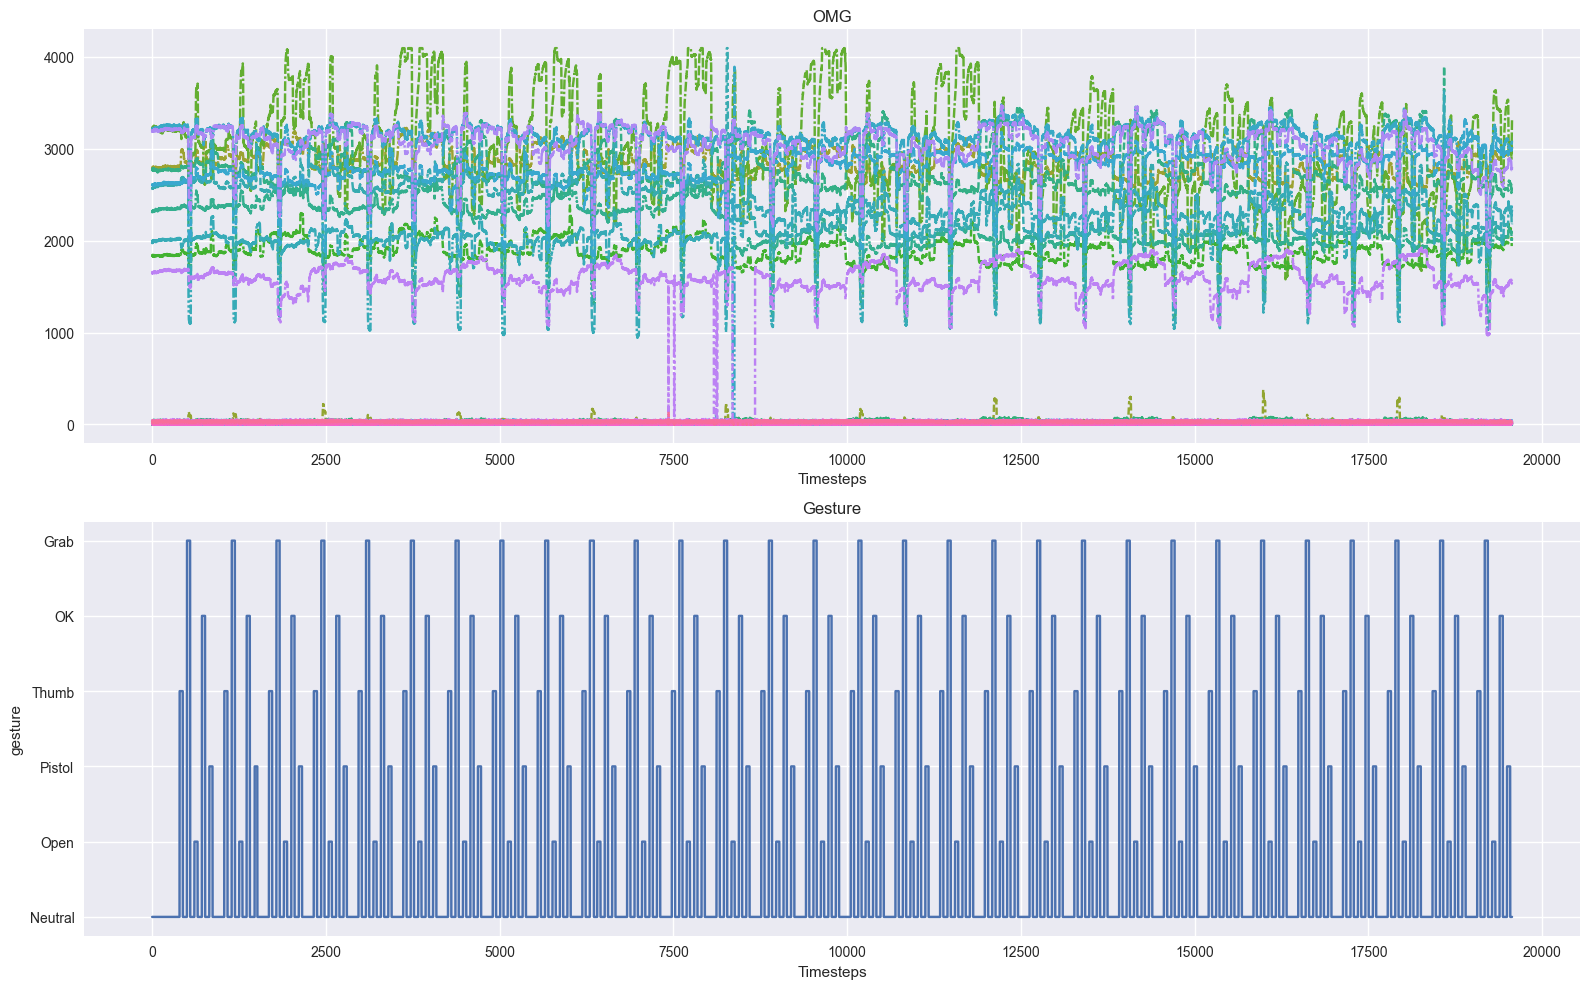

In [11]:
#Имена жестов
gestures_names = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

fig, axes = plt.subplots(2, 1, figsize=(16, 10))
#Графики датчиков
sns.lineplot(data.drop('gesture', axis=1), ax=axes[0], legend=False)
axes[0].set_title('OMG')
axes[0].set_xlabel('Timesteps')
#График таргета
sns.lineplot(data['gesture'], ax=axes[1], legend=False)
axes[1].set_title('Gesture')
axes[1].set_yticks(np.arange(len(gestures_names)), gestures_names)
axes[1].set_xlabel('Timesteps')
plt.tight_layout()

experiment.log_figure(figure=plt)

## Анализ данных

Рассмотрим наши временные ряды более локально, будем просматривать каждые 100 временных шагов.

{'web': 'https://www.comet.com/api/image/download?imageId=b7195367b2b64ebd809983e8525218a5&experimentKey=4fec13f9351f496c9b71103bd497ed6e',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=b7195367b2b64ebd809983e8525218a5&experimentKey=4fec13f9351f496c9b71103bd497ed6e',
 'imageId': 'b7195367b2b64ebd809983e8525218a5'}

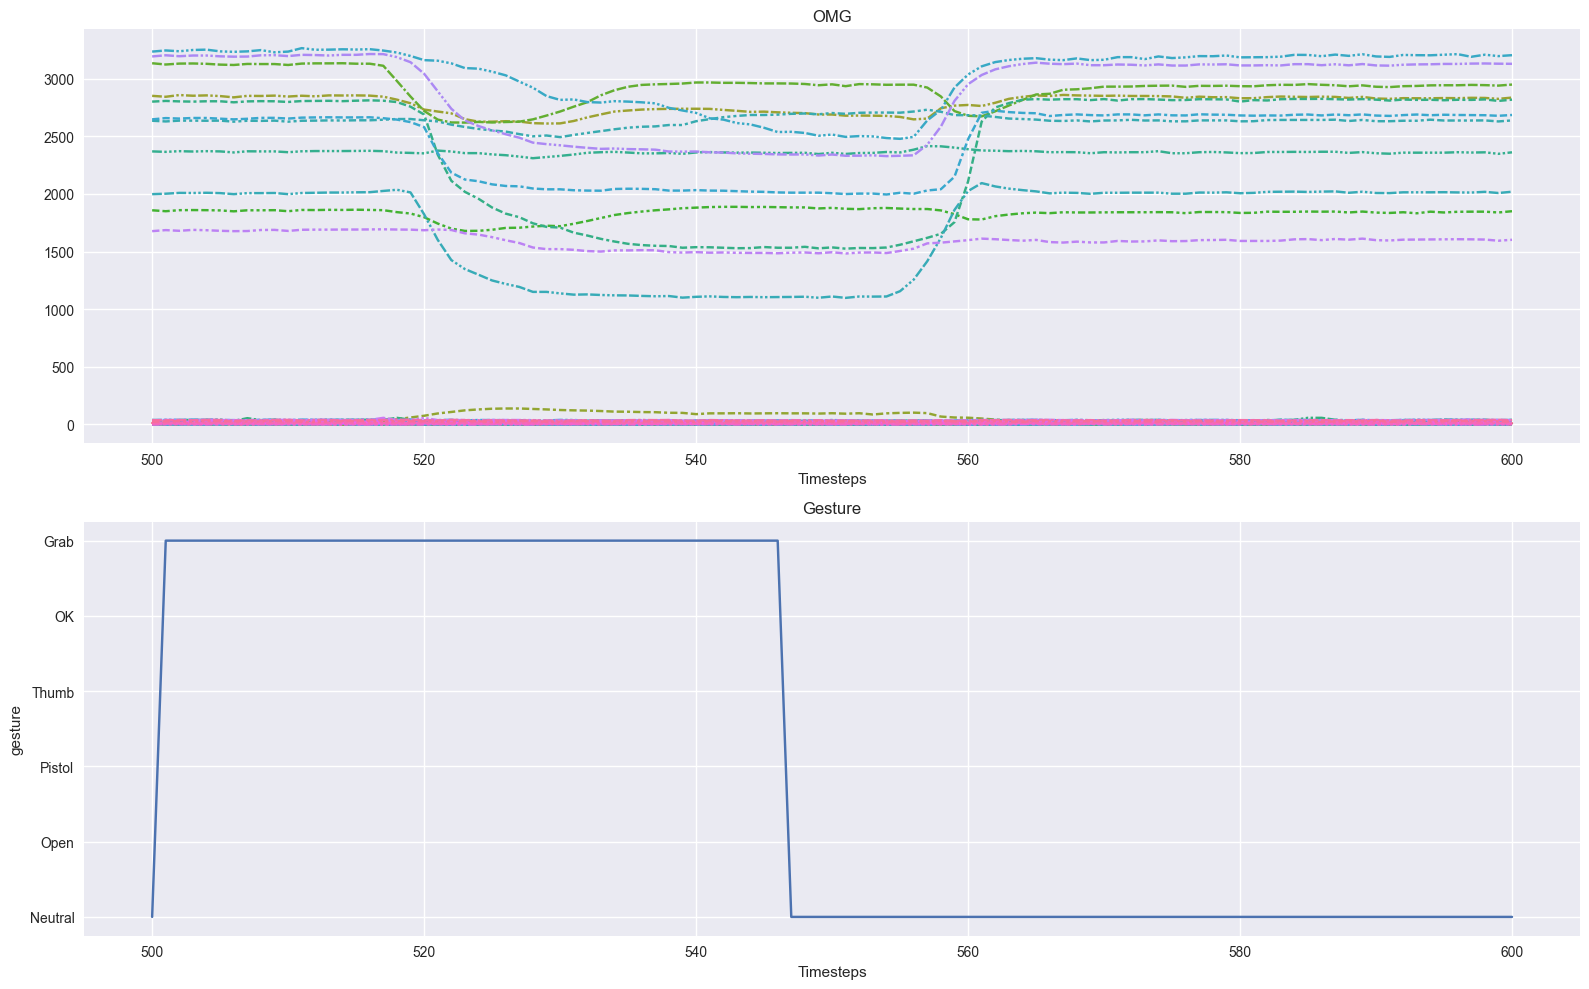

In [12]:
sample_number = 5

#Имена жестов
gestures_names = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

fig, axes = plt.subplots(2, 1, figsize=(16, 10))
#Графики датчиков
sns.lineplot(data.drop('gesture', axis=1).iloc[100 * sample_number: 100 * (sample_number + 1) + 1], ax=axes[0], legend=False)
axes[0].set_title('OMG')
axes[0].set_xlabel('Timesteps')
#График таргета
sns.lineplot(data['gesture'].iloc[100 * sample_number:100 * (sample_number + 1) + 1], ax=axes[1], legend=False)
axes[1].set_title('Gesture')
axes[1].set_yticks(np.arange(len(gestures_names)), gestures_names)
axes[1].set_xlabel('Timesteps')
plt.tight_layout()

experiment.log_figure(figure=plt)

### Удаление задержки

Если мы просмотрим несколько таких сэмплов, то сразу станет понятным, что в данных присутствует задержка, от которой необходимо избавиться.

Реализуем следующую идею: воспользуемся шифтером(сместим наши данные) на n количество временных шагов влево, число n подберем таким образом, чтобы взаимная корреляция временного ряда суммы абсолютных значений производных наших признаков с временным рядом выполнения жестов(число 1 - жест выполняется, число 0 - нейтральное положение руки) была максимальна.

n: 18, cor: 0.1734128465017738


{'web': 'https://www.comet.com/api/image/download?imageId=811f9cc0958e4fe6a4def7ccc072591b&experimentKey=4fec13f9351f496c9b71103bd497ed6e',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=811f9cc0958e4fe6a4def7ccc072591b&experimentKey=4fec13f9351f496c9b71103bd497ed6e',
 'imageId': '811f9cc0958e4fe6a4def7ccc072591b'}

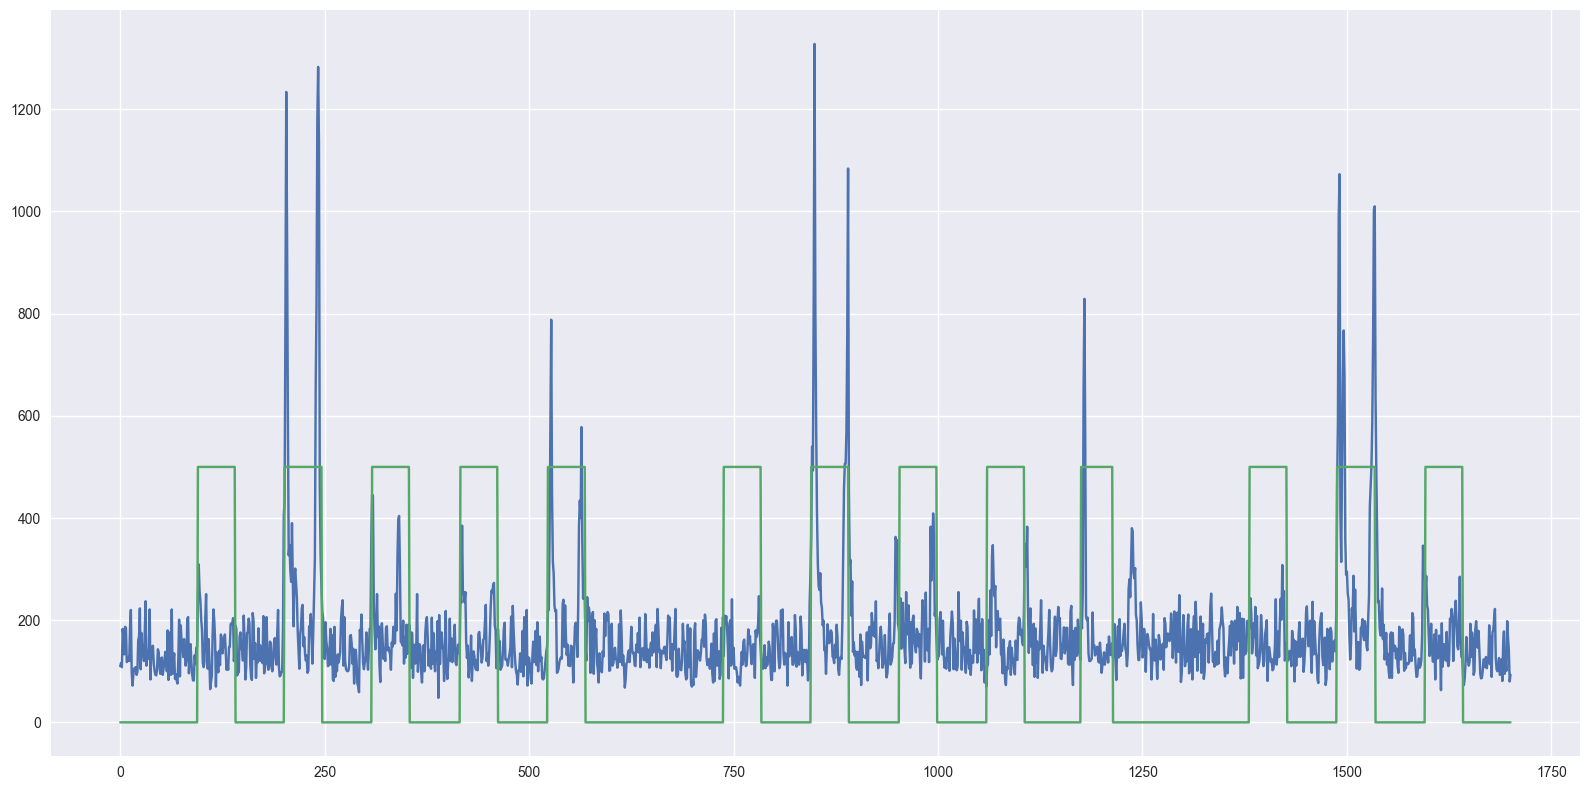

In [13]:
def data_shifter(data, n):
    """Смещает данные на n единиц

    Args:
        data: Данные
        n: Кол-во единиц

    Returns:
        X: Смещенные данные
    """
    X = data.drop('gesture', axis=1) #Матрица наблюдений
    y = data['gesture'] #Вектор правильных ответов
    #Смещаем данные
    X = X.iloc[n:].reset_index(drop=True)
    X['gesture'] = y.iloc[:-n].reset_index(drop=True)
    return X

def get_sum_derivative(data):
    """Возвращает сумму абсолютных значений производных

    Args:
        data: Наши данные

    Returns:
        result: Серия сумм абсолютных значений производных
    """
    result = abs(data.drop('gesture', axis=1).diff()).sum(axis=1)
    return result

def get_best_shifter(data, res_plot=False):
    #Формируем ряд выполнения жестов.
    gestures = data['gesture'].apply(lambda x: 500 if x > 0 else 0)
    #Ряд производных
    derivatives = get_sum_derivative(data)
    #Словарь с результатом
    result = {'n': 0, 'cor': 0}
    #Находим лучший шифтер
    for n in range(1, 41):
        cor = np.corrcoef(derivatives.iloc[n:].values, gestures.iloc[:-n].values)[0][1]
        if cor > result['cor']:
            result['n'] = n
            result['cor'] = cor
            
    if res_plot: #Если необходимо строим график с полученным сдвигом для первых 2000 таймстепов.
        fig, axes = plt.subplots(1, 1, figsize=(16, 8))
        sns.lineplot(derivatives.iloc[result['n']:].values[300:2001], ax=axes, legend=False)
        sns.lineplot(gestures.iloc[:-result['n']].values[300:2001], ax=axes, legend=False)
        plt.tight_layout()
    #Выводим результат    
    print(f'n: {result["n"]}, cor: {result["cor"]}')
    #Возвращаем словарь с найденным n и корреляцией
    return result
    
#Применяем полученную функцию
n = get_best_shifter(data, res_plot=True)['n']

experiment.log_figure(figure=plt)

Теперь к нашим данным применяем функцию data_shifter со значением n равным тому, что получили при использовании get_best_shifter.

In [14]:
#Применяем функцию
data = data_shifter(data, n)
print(f'Data shape: {data.shape}')
data

Data shape: (19550, 51)


,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,gesture
0,17,6,4,6,3,0,4,6,10,9,...,21,11,8,2,2,10,10,33,26,0
1,11,6,5,4,2,0,6,3,10,8,...,23,15,9,1,0,11,14,37,29,0
2,11,8,7,4,2,0,4,1,10,8,...,24,12,12,2,1,12,10,39,27,0
3,10,6,6,4,1,0,7,5,10,6,...,24,14,11,2,0,1,14,40,27,0
4,10,6,6,4,2,1,4,4,0,12,...,20,14,11,0,2,13,14,38,28,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19545,3,6,7,4,2,0,6,3,13,8,...,24,13,10,3,2,11,13,34,28,0
19546,26,6,5,3,2,1,4,4,9,7,...,21,13,10,3,2,10,12,34,27,0
19547,14,7,6,4,2,0,6,5,13,8,...,25,14,13,3,1,12,12,37,27,0
19548,30,6,6,4,2,0,5,5,10,6,...,20,4,9,3,0,13,11,37,27,0


Давайте посмотрим на графики после смещения.

{'web': 'https://www.comet.com/api/image/download?imageId=b2e5f5e3885a4692a3b6ed69852e299b&experimentKey=4fec13f9351f496c9b71103bd497ed6e',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=b2e5f5e3885a4692a3b6ed69852e299b&experimentKey=4fec13f9351f496c9b71103bd497ed6e',
 'imageId': 'b2e5f5e3885a4692a3b6ed69852e299b'}

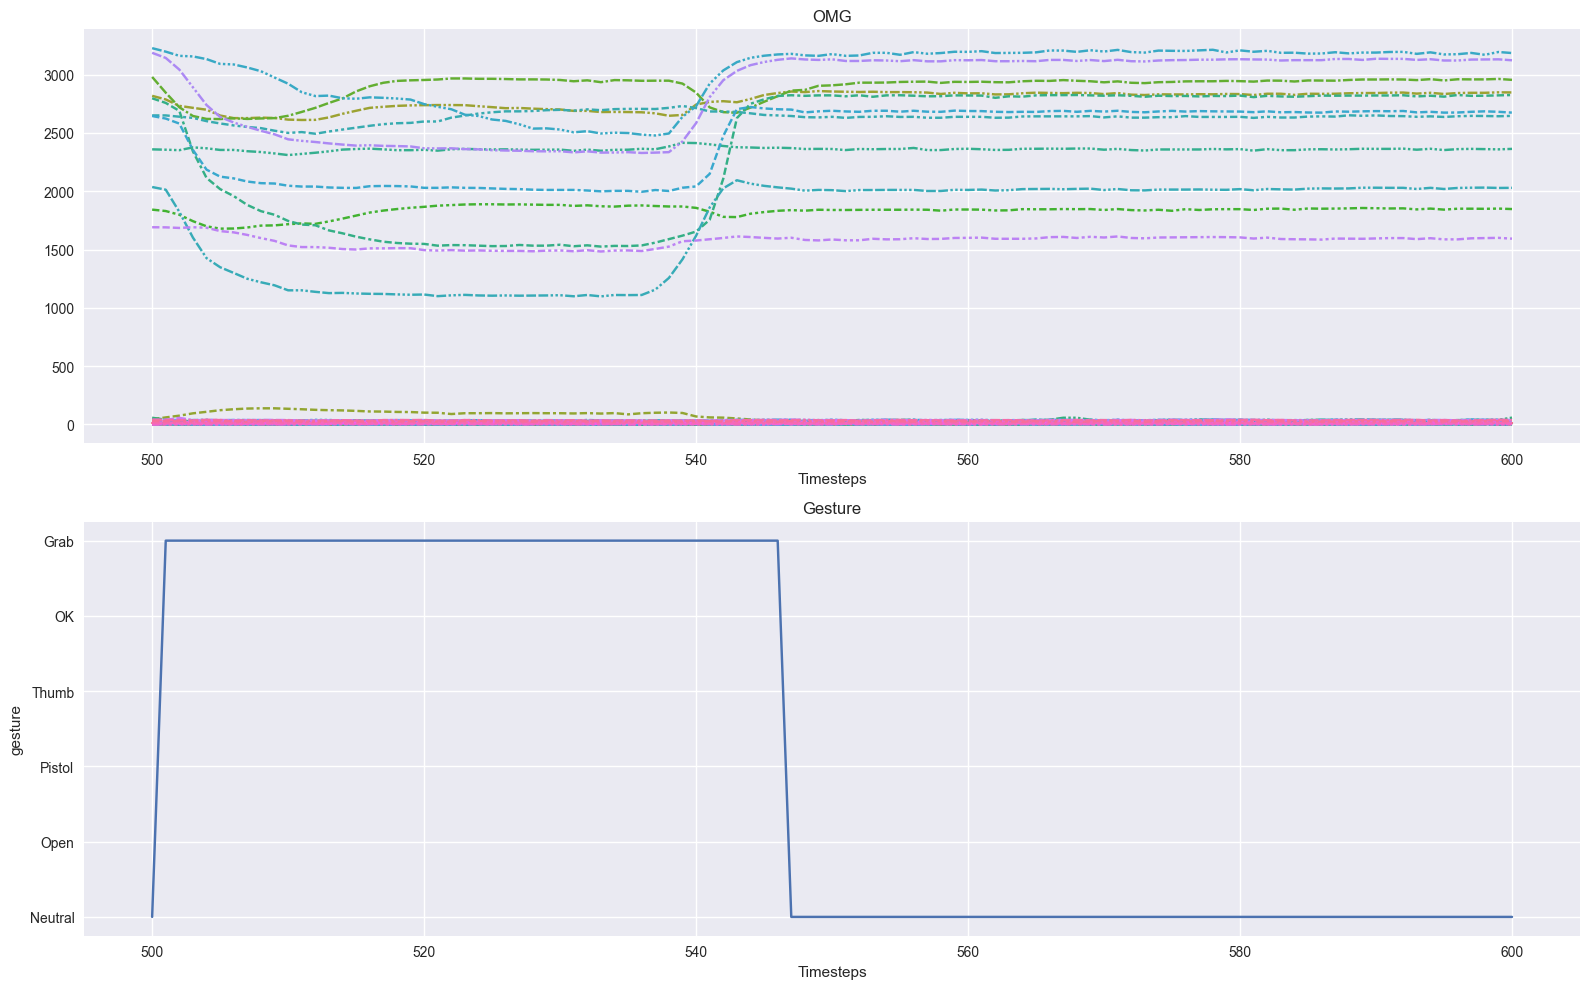

In [15]:
sample_number = 5

#Имена жестов
gestures_names = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

fig, axes = plt.subplots(2, 1, figsize=(16, 10))
#Графики датчиков
sns.lineplot(data.drop('gesture', axis=1).iloc[100 * sample_number: 100 * (sample_number + 1) + 1], ax=axes[0], legend=False)
axes[0].set_title('OMG')
axes[0].set_xlabel('Timesteps')
#График таргета
sns.lineplot(data['gesture'].iloc[100 * sample_number:100 * (sample_number + 1) + 1], ax=axes[1], legend=False)
axes[1].set_title('Gesture')
axes[1].set_yticks(np.arange(len(gestures_names)), gestures_names)
axes[1].set_xlabel('Timesteps')
plt.tight_layout()

experiment.log_figure(figure=plt)

### Генерация признаков

Давайте сгенерируем признаки из нашего датасета с различными таймстепами:

1. Производные для каждого признака и сумму производных.
2. Тренды (не изменяется - 0, убывает - 1, возрастает - 2).
3. Средние значения по показаниям с датчиков.

In [16]:
def get_trend(derivative):
    #Получает тренд из производной
    if derivative > 0:
        return 2
    elif derivative < 0:
        return 1
    else:
        return 0

def create_features(data, n_diff, sum_create=False, trend_create=False, mean_create=False):
    """Изначально создает признаки производных для наших данных, также можно добавить тренды, среднии значения.

    Args:
        data: Наши данные
        n_diff (_type_): Кол-во таймстепов для разницы
        sum_create (bool, optional): Если True, то добавит признак суммы производных. Defaults to False.
        trend_create (bool, optional): Если True, то добавит признаки трендов. Defaults to False.
        mean_create (bool, optional): Если True, то добавит признаки средних. Defaults to False.


    Returns:
        data: Данные со сгенерированными признаками
    """
    #Имена признаков
    col_names = [str(x) for x in range(50)]
    #Для каждого признака добавляем признак производных
    for col in col_names:
        data[f'{col}_diff_{n_diff}'] = data[col].diff(n_diff).fillna(0)
        if trend_create:
            data[f'{col}_trend_{n_diff}'] = data[f'{col}_diff_{n_diff}'].apply(get_trend)
        if mean_create:
            data[f'mean_{n_diff}'] = data.drop('gesture', axis=1).shift(n_diff).mean(axis=1).fillna(0)
        
        
    #Если надо, то добавляем сумму производных 
    if sum_create:
        data[f'sum_diff_{n_diff}'] = data[[f'{col}_diff_{n_diff}' for col in col_names]].sum(axis=1)
    #Возвращаем наши данные
    return data

def get_features(data, n_diff, count, sum_create=False, trend_create=False, mean_create=False):
    #Добавляет признаки к нашим данным от n_diff до n_diff * count отступов
    for i in range(1, count + 1):
        data = create_features(data, n_diff * i, sum_create=sum_create, trend_create=trend_create, mean_create=mean_create)
    #Возвращаем данные со сгенерированными признаками    
    return data
        
data = get_features(data, 5, 3, sum_create=True, trend_create=True, mean_create=True)
print(f'Data shape: {data.shape}')
print(f'Итоговые столбцы:\n {data.columns.tolist()}')
data.head()

Data shape: (19550, 357)
Итоговые столбцы:
 ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', 'gesture', '0_diff_5', '0_trend_5', 'mean_5', '1_diff_5', '1_trend_5', '2_diff_5', '2_trend_5', '3_diff_5', '3_trend_5', '4_diff_5', '4_trend_5', '5_diff_5', '5_trend_5', '6_diff_5', '6_trend_5', '7_diff_5', '7_trend_5', '8_diff_5', '8_trend_5', '9_diff_5', '9_trend_5', '10_diff_5', '10_trend_5', '11_diff_5', '11_trend_5', '12_diff_5', '12_trend_5', '13_diff_5', '13_trend_5', '14_diff_5', '14_trend_5', '15_diff_5', '15_trend_5', '16_diff_5', '16_trend_5', '17_diff_5', '17_trend_5', '18_diff_5', '18_trend_5', '19_diff_5', '19_trend_5', '20_diff_5', '20_trend_5', '21_diff_5', '21_trend_5', '22_diff_5', '22_trend_5', '23_diff_5', '23_trend_5', '24_diff_5', '24

,0,1,2,3,4,5,6,7,8,9,...,45_trend_15,46_diff_15,46_trend_15,47_diff_15,47_trend_15,48_diff_15,48_trend_15,49_diff_15,49_trend_15,sum_diff_15
0,17,6,4,6,3,0,4,6,10,9,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
1,11,6,5,4,2,0,6,3,10,8,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
2,11,8,7,4,2,0,4,1,10,8,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
3,10,6,6,4,1,0,7,5,10,6,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
4,10,6,6,4,2,1,4,4,0,12,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


### Сбалансированность классов

Посмотрим на распределение целевой переменной.

Text(0.5, 1.0, 'Баланс классов')

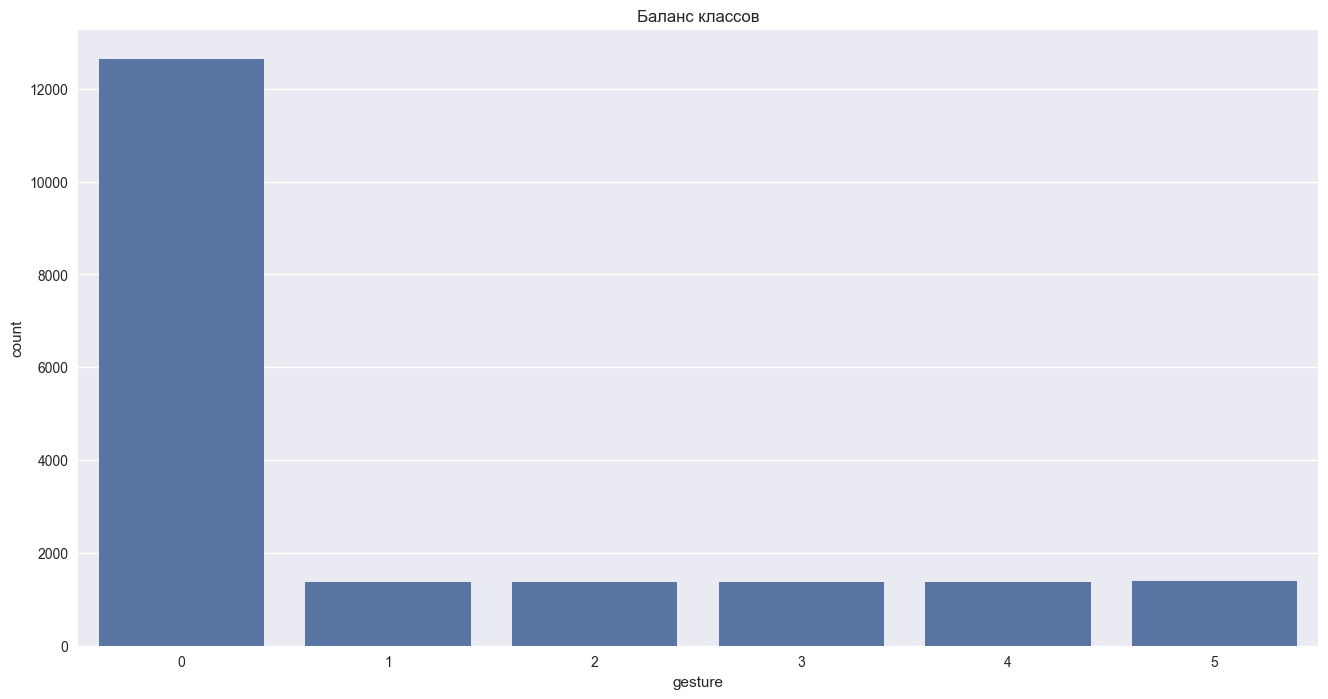

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.countplot(data, x='gesture', ax=ax)
ax.set_title('Баланс классов')

Видим, что классы несбалансированны, возможно для улучшения прогноза это надо будет исправить.

## Подготовка данных к подаче в модель

### Train/Test
Перейдем к подготовке наших данных. Для начала разделяем выборку на тестовую, валидационную и тренировочную, размер разделений 0.2/0.2/0.6.

In [18]:
X = data.drop('gesture', axis=1)
y = data['gesture']

test_start_index = round(data.shape[0] * 0.8)

X_train = X.iloc[:test_start_index]
X_test = X.iloc[test_start_index:].reset_index(drop=True)
y_train = y.iloc[:test_start_index]
y_test = y.iloc[test_start_index:]

assert data.shape[0] == X_train.shape[0] + X_test.shape[0]

print(f'Train shape: {X_train.shape}')
print(f'Test shape: {X_test.shape}')

Train shape: (15640, 356)
Test shape: (3910, 356)


## Стандартизация данных

Так как при сборе данных статистические характеристики наших временных рядов зависят от внешних факторов и пилота, с которого собираются данные, то для каждого временного ряда одни и те же признаки будут иметь разный масштаб, среднее и т.д.

Поэтому был реализован OnlineStandartScaler, который производит онлайн стандартизацию, изменяя статистики с каждым новым объектом.
Применим его для обучающей и отдельно для тестовой выборки.

In [19]:
#Стандартизируем обучающую выборку
train_scaler = OnlineStandartScaler()
for idx, row in X_train.iterrows():
   row_scaled = train_scaler.fit_transform(row)
   X_train.loc[idx, :] = row_scaled
#Стандартизируем тренировочную выборку
test_scaler = OnlineStandartScaler()
for idx, row in X_test.iterrows():
   row_scaled = test_scaler.fit_transform(row)
   X_test.loc[idx, :] = row_scaled

## Отбор признаков

Реализуем отбор признаков.

In [20]:
selector = SelectKBest(f_classif, k=40)
selector.fit(X_train, y_train)

selected_features = selector.get_feature_names_out()
X_train = X_train[selected_features]
X_test = X_test[selected_features]

print(f'Отобранные признаки: {selector.get_feature_names_out()}')
print(f'Train Data shape: {X_train.shape}')
print(f'Test Data shape: {X_test.shape}')

log_model(experiment, model=selector, model_name='Feature Selector')

Отобранные признаки: ['11' '13' '14' '18' '20' '23' '26' '29' '32' '33' '37' '43' 'mean_5'
 '21_diff_5' '38_diff_5' 'sum_diff_5' 'mean_10' '12_diff_10' '16_diff_10'
 '16_trend_10' '21_diff_10' '28_diff_10' '30_diff_10' '31_diff_10'
 '38_diff_10' 'sum_diff_10' 'mean_15' '12_diff_15' '16_diff_15'
 '16_trend_15' '21_diff_15' '27_diff_15' '28_diff_15' '28_trend_15'
 '30_diff_15' '30_trend_15' '31_diff_15' '38_diff_15' '38_trend_15'
 'sum_diff_15']
Train Data shape: (15640, 40)
Test Data shape: (3910, 40)


## Построение модели

Начнем с решающего дерева. Подбор гиперпараметров реализуем с помощью GridSearchCV.

In [21]:
#Модель
dt_model = DecisionTreeClassifier(random_state=random_seed)
#Сетка параметров
param_grid = {
    'max_depth': np.arange(1, 100, 10),
    'min_samples_leaf': np.arange(1, 20, 4),
    'criterion': ['gini', 'entropy']
}
#Валидатор
tscv = TimeSeriesSplit(n_splits=3) 
#Подбор гиперпараметров
grid_dt = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid,
    cv=tscv,
    n_jobs=-1
)
#Обучаем модель
grid_dt.fit(X_train, y_train)
print(f'best params: {grid_dt.best_params_}')
#Делаем предсказания на тренировочном наборе данных
y_train_predict = grid_dt.predict(X_train)
print(f'Train classification report:\n {metrics.classification_report(y_train, y_train_predict)}')
print(f'Mean-f1 train:  {metrics.f1_score(y_train, y_train_predict, average=None).mean()}')
#Делаем предсказания на тестовом наборе данных
y_test_predict = grid_dt.predict(X_test)
print(f'Test classification report:\n {metrics.classification_report(y_test, y_test_predict)}')
print(f'Mean-f1 test:  {metrics.f1_score(y_test, y_test_predict, average=None).mean()}')

dt_metrics = {'f1_mean': metrics.f1_score(y_test, y_test_predict, average=None).mean()}
experiment.log_parameters(grid_dt.best_params_)
experiment.log_metrics(dt_metrics)
log_model(experiment, model=grid_dt.best_estimator_, model_name='Decision Tree Classifier')

best params: {'criterion': 'entropy', 'max_depth': 11, 'min_samples_leaf': 9}
Train classification report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94     10151
           1       0.89      0.90      0.90      1104
           2       0.89      0.80      0.84      1059
           3       0.84      0.55      0.66      1104
           4       0.89      0.73      0.80      1104
           5       0.98      0.96      0.97      1118

    accuracy                           0.90     15640
   macro avg       0.90      0.82      0.85     15640
weighted avg       0.90      0.90      0.90     15640

Mean-f1 train:  0.8514168743753285
Test classification report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.85      2490
           1       0.55      0.72      0.62       276
           2       0.66      0.56      0.60       315
           3       0.60      0.40      0.48       276
           4  

Попробуем модель случайного леса

In [22]:
#Модель
rf_model = RandomForestClassifier(max_depth=11, min_samples_leaf=9, criterion='entropy', random_state=random_seed)
#Сетка параметров
param_grid = {
    'n_estimators': np.arange(30, 300, 30)
}
#Подбор гиперпараметров
grid_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=tscv,
    n_jobs=-1
)
#Обучаем модель
grid_rf.fit(X_train, y_train)
print(f'best params: {grid_rf.best_params_}')
#Делаем предсказания на тренировочном наборе данных
y_train_predict = grid_rf.predict(X_train)
print(f'Train classification report:\n {metrics.classification_report(y_train, y_train_predict)}')
print(f'Mean-f1 train:  {metrics.f1_score(y_train, y_train_predict, average=None).mean()}')
#Делаем предсказания на тестовом наборе данных
y_test_predict = grid_rf.predict(X_test)
print(f'Test classification report:\n {metrics.classification_report(y_test, y_test_predict)}')
print(f'Mean-f1 test:  {metrics.f1_score(y_test, y_test_predict, average=None).mean()}')

rf_metrics = {'f1_mean': metrics.f1_score(y_test, y_test_predict, average=None).mean()}
experiment.log_parameters(grid_rf.best_params_)
experiment.log_metrics(rf_metrics)
log_model(experiment, model=grid_rf.best_estimator_, model_name='Random Forest Classifier')

best params: {'n_estimators': 180}
Train classification report:
               precision    recall  f1-score   support

           0       0.90      0.99      0.94     10151
           1       0.98      0.91      0.95      1104
           2       0.99      0.81      0.89      1059
           3       0.98      0.51      0.67      1104
           4       0.98      0.76      0.86      1104
           5       0.99      0.97      0.98      1118

    accuracy                           0.92     15640
   macro avg       0.97      0.82      0.88     15640
weighted avg       0.93      0.92      0.92     15640

Mean-f1 train:  0.8805959421023349
Test classification report:
               precision    recall  f1-score   support

           0       0.83      0.98      0.90      2490
           1       0.93      0.81      0.86       276
           2       0.91      0.48      0.63       315
           3       0.90      0.23      0.37       276
           4       0.90      0.68      0.78       276
   

Модели бустингов из xgboost и catboost.

In [23]:
#Обучаем модель
gb_model = xgboost.XGBClassifier(random_state=random_seed)
gb_model.fit(X_train, y_train)
#Делаем предсказания на тренировочном наборе данных
y_train_predict = gb_model.predict(X_train)
print(f'Train classification report:\n {metrics.classification_report(y_train, y_train_predict)}')
print(f'Mean-f1 train:  {metrics.f1_score(y_train, y_train_predict, average=None).mean()}')
#Делаем предсказания на тестовом наборе данных
y_test_predict = gb_model.predict(X_test)
print(f'Test classification report:\n {metrics.classification_report(y_test, y_test_predict)}')
print(f'Mean-f1 test:  {metrics.f1_score(y_test, y_test_predict, average=None).mean()}')

Train classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10151
           1       1.00      1.00      1.00      1104
           2       1.00      1.00      1.00      1059
           3       1.00      1.00      1.00      1104
           4       1.00      1.00      1.00      1104
           5       1.00      1.00      1.00      1118

    accuracy                           1.00     15640
   macro avg       1.00      1.00      1.00     15640
weighted avg       1.00      1.00      1.00     15640

Mean-f1 train:  1.0
Test classification report:
               precision    recall  f1-score   support

           0       0.87      0.97      0.92      2490
           1       0.89      0.87      0.88       276
           2       0.90      0.71      0.80       315
           3       0.87      0.37      0.52       276
           4       0.91      0.80      0.86       276
           5       0.92      0.88      0.90       277

In [24]:
#Обучаем модель
cat_model = catboost.CatBoostClassifier(random_state=random_seed)
cat_model.fit(X_train, y_train)
#Делаем предсказания на тренировочном наборе данных
y_train_predict = cat_model.predict(X_train)
print(f'Train classification report:\n {metrics.classification_report(y_train, y_train_predict)}')
print(f'Mean-f1 train:  {metrics.f1_score(y_train, y_train_predict, average=None).mean()}')
#Делаем предсказания на тестовом наборе данных
y_test_predict = cat_model.predict(X_test)
print(f'Test classification report:\n {metrics.classification_report(y_test, y_test_predict)}')
print(f'Mean-f1 test:  {metrics.f1_score(y_test, y_test_predict, average=None).mean()}')

Learning rate set to 0.091039
0:	learn: 1.5728949	total: 166ms	remaining: 2m 45s
1:	learn: 1.4273270	total: 180ms	remaining: 1m 29s
2:	learn: 1.3112033	total: 195ms	remaining: 1m 4s
3:	learn: 1.2179293	total: 210ms	remaining: 52.3s
4:	learn: 1.1378297	total: 227ms	remaining: 45.2s
5:	learn: 1.0734303	total: 243ms	remaining: 40.3s
6:	learn: 1.0189435	total: 260ms	remaining: 36.8s
7:	learn: 0.9671624	total: 275ms	remaining: 34.1s
8:	learn: 0.9226290	total: 290ms	remaining: 32s
9:	learn: 0.8881836	total: 307ms	remaining: 30.4s
10:	learn: 0.8523923	total: 323ms	remaining: 29.1s
11:	learn: 0.8252394	total: 340ms	remaining: 28s
12:	learn: 0.8015140	total: 356ms	remaining: 27.1s
13:	learn: 0.7752753	total: 373ms	remaining: 26.3s
14:	learn: 0.7519927	total: 391ms	remaining: 25.7s
15:	learn: 0.7303218	total: 409ms	remaining: 25.2s
16:	learn: 0.7096672	total: 426ms	remaining: 24.6s
17:	learn: 0.6920762	total: 442ms	remaining: 24.1s
18:	learn: 0.6731402	total: 459ms	remaining: 23.7s
19:	learn: 0.

## Улучшение предсказания сгиба большого пальца

Можно заметить, что модели плохо предсказывают сгиб большого пальца, дело в том, что он плохо отличим от нейтрального положения. Давайте обучим две модели последовательно, первая будет делать предсказания на всех данных, а вторая модель на тех данных, которые были предсказаны первой моделью как классы 0 и 3, чтобы улучшить предсказания для плохо отличимого жеста.

За первую модель возьмем ту, что показала лучшие метрики на тесте - случайный лес.

In [25]:
first_model = grid_rf.best_estimator_
first_model_train_pred = first_model.predict(X_train)
first_model_test_pred = first_model.predict(X_test)

Формируем данные для обучения второй модели и обучаем ее, воспользуемся также случайным лесом.

In [26]:
#Обучающая выборка
X_train_for_second_model = X_train[(first_model_train_pred == 0) | (first_model_train_pred == 3)]
y_train_for_second_model = y_train[(first_model_train_pred == 0) | (first_model_train_pred == 3)].apply(lambda x: 3 if x == 3 else 0)
#Тренировочная выборка
X_test_for_second_model = X_test[(first_model_test_pred == 0) | (first_model_test_pred == 3)]
y_test_for_second_model = y_test[(first_model_test_pred == 0) | (first_model_test_pred == 3)].apply(lambda x: 3 if x == 3 else 0)
#Индексы элементов в исходной выборке
X_train_indexes = X_train_for_second_model.index
X_test_indexes = X_test_for_second_model.index

#Модель
rf_model = RandomForestClassifier(max_depth=11, min_samples_leaf=9, criterion='entropy', random_state=random_seed)
#Сетка параметров
param_grid = {
    'n_estimators': np.arange(30, 300, 30)
}
#Подбор гиперпараметров
seconf_grid_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=tscv,
    n_jobs=-1
)
#Обучаем модель
seconf_grid_rf.fit(X_train_for_second_model, y_train_for_second_model)
second_model = seconf_grid_rf.best_estimator_ 
#Делаем предсказания
second_model_train_pred = second_model.predict(X_train_for_second_model)
second_model_test_pred = second_model.predict(X_test_for_second_model)
#Собираем итоговые предсказания двух моделей
#Тренировочные
total_train_pred = first_model_train_pred
total_train_pred[X_train_indexes] = second_model_train_pred
print(f'Train classification report:\n {metrics.classification_report(y_train, total_train_pred)}')
print(f'Mean-f1 train:  {metrics.f1_score(y_train, total_train_pred, average=None).mean()}')
#Тестовые
total_test_pred = first_model_test_pred
total_test_pred[X_test_indexes] = second_model_test_pred
print(f'Test classification report:\n {metrics.classification_report(y_test, total_test_pred)}')
print(f'Mean-f1 test:  {metrics.f1_score(y_test, total_test_pred, average=None).mean()}')

Train classification report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95     10151
           1       0.98      0.91      0.95      1104
           2       0.99      0.81      0.89      1059
           3       0.99      0.68      0.81      1104
           4       0.98      0.76      0.86      1104
           5       0.99      0.97      0.98      1118

    accuracy                           0.94     15640
   macro avg       0.97      0.85      0.91     15640
weighted avg       0.94      0.94      0.93     15640

Mean-f1 train:  0.9051642833399081
Test classification report:
               precision    recall  f1-score   support

           0       0.83      0.98      0.90      2490
           1       0.93      0.81      0.86       276
           2       0.91      0.48      0.63       315
           3       0.91      0.27      0.41       276
           4       0.90      0.68      0.78       276
           5       0.91      0.90     

In [27]:
#experiment.end()

COMET ERROR: Heartbeat processing error
